<a href="https://colab.research.google.com/github/pesfahanian/Kaggle_Pneumonia_InceptionV3/blob/main/Kaggle_Pneumonia_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Pneumonia/chest_xray

/content/drive/MyDrive/Pneumonia/chest_xray


In [2]:
!ls

EfficientNet.h5  __MACOSX	 pneumonia.h5  train
foo.pdf		 model_vgg16.h5  test	       val


In [16]:
import glob
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from itertools import cycle

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import keras_preprocessing
from keras.models import load_model
from keras_preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

In [4]:
train_path      =   '/content/drive/MyDrive/Pneumonia/chest_xray/train'
validation_path =   '/content/drive/MyDrive/Pneumonia/chest_xray/val'
test_path       =   '/content/drive/MyDrive/Pneumonia/chest_xray/test'

In [7]:
train_NORMAL = len(glob.glob(train_path + '/NORMAL/*'))
train_PNEUMONIA = len(glob.glob(train_path + '/PNEUMONIA/*'))

validation_NORMAL = len(glob.glob(validation_path + '/NORMAL/*'))
validation_PNEUMONIA = len(glob.glob(validation_path + '/PNEUMONIA/*'))

test_NORMAL = len(glob.glob(test_path + '/NORMAL/*'))
test_PNEUMONIA = len(glob.glob(test_path + '/PNEUMONIA/*'))

print('Train:', train_NORMAL, 'NORMAL,', train_PNEUMONIA, 'PNEUMONIA.')
print('Validation:', validation_NORMAL, 'NORMAL,', validation_PNEUMONIA, 'PNEUMONIA.')
print('Test:', test_NORMAL, 'NORMAL,', test_PNEUMONIA, 'PNEUMONIA.')

Train: 1300 NORMAL, 3834 PNEUMONIA.
Validation: 49 NORMAL, 49 PNEUMONIA.
Test: 234 NORMAL, 390 PNEUMONIA.


In [8]:
IMG_SIZE    =   224
num_classes =   2
epochs      =   10
batch_size  =   16

In [27]:
train_datagen = ImageDataGenerator(rescale          =   1./255,
                                   rotation_range   =   10,
                                   shear_range      =   0.1,
                                   zoom_range       =   0.1,
                                   horizontal_flip  =   False)
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size =   (IMG_SIZE, IMG_SIZE),
                                                    class_mode  =   'categorical',
                                                    batch_size  =   batch_size,
                                                    shuffle     =   True)

validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_path,
                                                              target_size =   (IMG_SIZE, IMG_SIZE),
                                                              class_mode  =   'categorical',
                                                              batch_size  =   batch_size,
                                                              shuffle     =   False)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size =   (IMG_SIZE, IMG_SIZE),
                                                  class_mode  =   'categorical',
                                                  batch_size  =   batch_size,
                                                  shuffle     =   False)

Found 5134 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


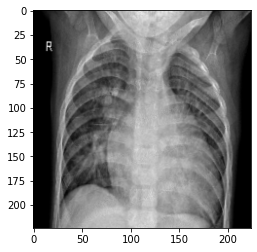

In [10]:
x, y = train_generator.next()
for i in range(0, 1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [11]:
URL = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4' 
feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224, 3))
feature_extractor.trainable = False

In [12]:
model = tf.keras.models.Sequential(
    [
     feature_extractor,
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(num_classes, activation='softmax')
    ]
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 21,938,210
Trainable params: 135,426
Non-trainable params: 21,802,784
______________________________________

In [22]:
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

In [17]:
save_path = "EfficientNet2.h5"
checkpoint = ModelCheckpoint(save_path,
                             monitor        =   'val_accuracy',
                             verbose        =   1,
                             save_best_only =   True,
                             mode           =   'max')
callbacks = [checkpoint]

In [23]:
model.compile(optimizer =   tf.optimizers.Adam(learning_rate=0.0001),
              loss      =   'binary_crossentropy',
              metrics   =   METRICS )

In [24]:
history = model.fit(train_generator,
                    epochs              =   epochs,
                    callbacks           =   [callbacks],
                    validation_data     =   validation_generator,
                    use_multiprocessing =   True,
                    workers             =   4)

Epoch 1/10


320/321 [============================>.] - ETA: 2s - loss: 0.3265 - accuracy: 0.8529 - precision: 0.8529 - recall: 0.8529WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.3261 - accuracy: 0.8531 - precision: 0.8531 - recall: 0.8531WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00001: val_accuracy improved from -inf to 0.86735, saving model to EfficientNet2.h5
321/321 [==============================] - 889s 3s/step - loss: 0.3261 - accuracy: 0.8531 - precision: 0.8531 - recall: 0.8531 - val_loss: 0.3119 - val_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 2/10


320/321 [============================>.] - ETA: 0s - loss: 0.2182 - accuracy: 0.9150 - precision: 0.9150 - recall: 0.9150WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00002: val_accuracy did not improve from 0.86735
321/321 [==============================] - 95s 295ms/step - loss: 0.2178 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - val_loss: 0.3168 - val_accuracy: 0.8469 - val_precision: 0.8469 - val_recall: 0.8469
Epoch 3/10


321/321 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00003: val_accuracy did not improve from 0.86735
321/321 [==============================] - 91s 284ms/step - loss: 0.2008 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - val_loss: 0.3400 - val_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 4/10


320/321 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00004: val_accuracy improved from 0.86735 to 0.89796, saving model to EfficientNet2.h5
321/321 [==============================] - 95s 297ms/step - loss: 0.1790 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - val_loss: 0.2394 - val_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 5/10


321/321 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00005: val_accuracy improved from 0.89796 to 0.90816, saving model to EfficientNet2.h5
321/321 [==============================] - 95s 297ms/step - loss: 0.1679 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - val_loss: 0.2360 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 6/10


320/321 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00006: val_accuracy improved from 0.90816 to 0.91837, saving model to EfficientNet2.h5
321/321 [==============================] - 95s 296ms/step - loss: 0.1697 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - val_loss: 0.1653 - val_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 7/10


321/321 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449


Epoch 00007: val_accuracy improved from 0.91837 to 0.93878, saving model to EfficientNet2.h5
321/321 [==============================] - 96s 299ms/step - loss: 0.1447 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - val_loss: 0.1495 - val_accuracy: 0.9388 - val_precision: 0.9388 - val_recall: 0.9388
Epoch 8/10


321/321 [==============================] - ETA: 0s - loss: 0.1482 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00008: val_accuracy did not improve from 0.93878
321/321 [==============================] - 91s 283ms/step - loss: 0.1482 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - val_loss: 0.2348 - val_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 9/10


320/321 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00009: val_accuracy did not improve from 0.93878
321/321 [==============================] - 91s 284ms/step - loss: 0.1371 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - val_loss: 0.2028 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 10/10


320/321 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00010: val_accuracy did not improve from 0.93878
321/321 [==============================] - 91s 284ms/step - loss: 0.1386 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - val_loss: 0.1565 - val_accuracy: 0.9388 - val_precision: 0.9388 - val_recall: 0.9388


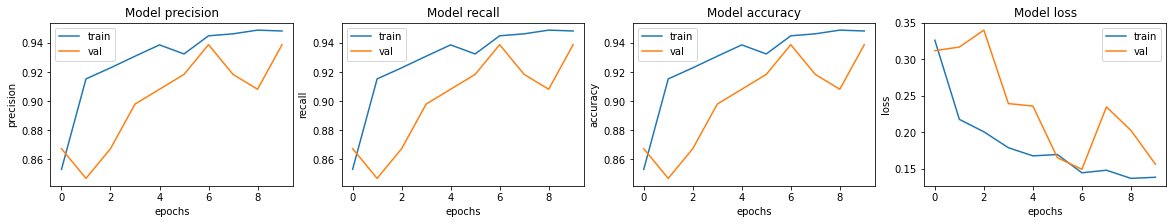

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
model.evaluate(test_generator)

39/39 [==============================] - 6s 163ms/step - loss: 0.3942 - accuracy: 0.8558 - precision: 0.8558 - recall: 0.8558


[0.3942283093929291,
 0.8557692170143127,
 0.8557692170143127,
 0.8557692170143127]

In [29]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


Instructions for updating:
Please use Model.predict, which supports generators.


In [30]:
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.92      0.68      0.78       234
   PNEUMONIA       0.83      0.96      0.89       390

    accuracy                           0.86       624
   macro avg       0.88      0.82      0.84       624
weighted avg       0.86      0.86      0.85       624



In [33]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize =   False,
                          title     =   'Confusion matrix',
                          cmap      =   plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=90, va="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize = 15,
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


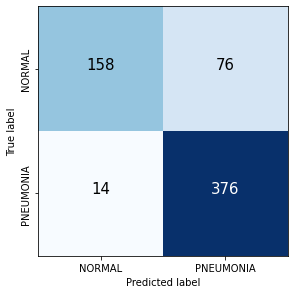

In [34]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')